In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#channel a
#mem_coeffs = [(0.1,0),(0.25,1), (0.16,2), (0.08,3),(0.04,4)]
#channel b
mem_coeffs = [(0.23,0),(0.46,1), (0.69,2), (0.23,3)]
#channel c
#mem_coeffs = [(0.2,1),(0.3,1.85), (0.15,2.55), (0.25,3.35),(0.5,4.6)]

In [3]:
#finding the greatest common divisor of all mem_coeffs[i][0] (minimum 0.01)
lowest_count = 0
for i in range(1,101):
    int_arr = (i*np.array([x[1] for x in mem_coeffs])).astype("int")
    float_arr = i*np.array([x[1] for x in mem_coeffs])
    if np.array_equal(int_arr, float_arr):
        lowest_count = i
        break
lowest_count

1

In [4]:
delay_array = np.array([x[1] for x in mem_coeffs])
mem_amp_coeffs = np.array([x[0] for x in mem_coeffs])
if delay_array[0] != 0:
    delay_array = np.insert(delay_array,0,0)
    mem_amp_coeffs = np.insert(mem_amp_coeffs,0,0)

diff_delay_array = (np.diff(delay_array)*lowest_count).astype("int")
counter = 0
i = 0
while True:
    if mem_amp_coeffs[i] != 0 or i==0:
        mem_amp_coeffs = np.insert(mem_amp_coeffs,i+1,np.zeros(diff_delay_array[counter]-1))
        counter += 1
    if counter == len(diff_delay_array):
        break
    i += 1

In [5]:
def rc_filter(sampling_freq, roll_off):
    t = np.arange(-2,2, 1/float(sampling_freq))
    rc = np.piecewise(t, [t==0, np.abs(t) == 1/float(2*roll_off), (t!=0) & (np.abs(t) != 1/float(2*roll_off))], 
                     [lambda t:1,  lambda t: np.pi/4*np.sin(np.pi/(2*roll_off))/(np.pi/(2*roll_off)), lambda t:
                     np.sin(np.pi*t)/(np.pi*t)*np.cos(roll_off*np.pi*t)/(1-(2*roll_off*t)**2)])

    return rc

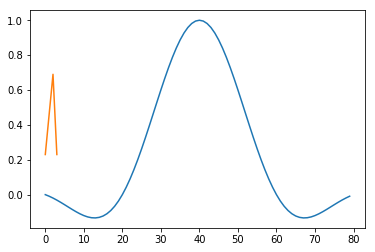

In [6]:
filt = rc_filter(20,0.5)
plt.plot(filt)
plt.plot(mem_amp_coeffs)

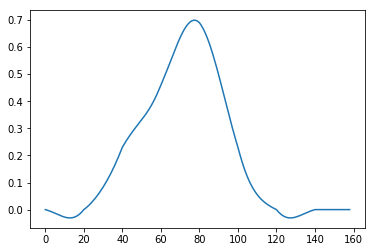

In [7]:
plot_coeffs = mem_amp_coeffs.reshape(len(mem_amp_coeffs),-1)
plot_coeffs = np.pad(plot_coeffs,[(0,0),(0,19)], 'constant',constant_values=(0))
plot_coeffs = plot_coeffs.reshape(-1)
s = np.convolve(plot_coeffs,filt, mode="full")
plt.plot(s)

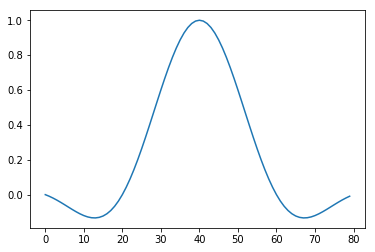

In [8]:
plt.plot(filt)

In [9]:
conv_seq = np.zeros((5,20))
for i in range(conv_seq.shape[0]):
    conv_seq[i] = np.linspace(1,20,num=20)
oversampling_fact = 20
output_overs = 5

In [10]:
keep_distance = int(oversampling_fact/output_overs)+1
keep_point = np.floor(oversampling_fact/2)+1
keep_mask = [int(keep_point)]
for i in range(1,int(oversampling_fact/2)):
    if i*keep_distance+keep_point < oversampling_fact:
        keep_mask.append(int(keep_point+i*keep_distance))
    if keep_point - i*keep_distance > 0:
        keep_mask.append(int(keep_point- i*keep_distance))
keep_mask = np.sort(keep_mask)-1
print(keep_mask)
conv_seq = conv_seq.reshape(-1,oversampling_fact)
conv_seq = np.take(conv_seq,keep_mask, axis=1)
conv_seq

4
[ 2  6 10 14 18]


array([[ 3.,  7., 11., 15., 19.],
       [ 3.,  7., 11., 15., 19.],
       [ 3.,  7., 11., 15., 19.],
       [ 3.,  7., 11., 15., 19.],
       [ 3.,  7., 11., 15., 19.]])

### Test eine Kovarianzmatrix zu erzeugen, 
sodass der erzeugte Zufallsvektor gleich die Eigenschaften des gefilterten Rauschens hat

In [44]:
def rrc_filter(sampling_freq, roll_off):
        t = np.arange(-2,2+1/sampling_freq, 1/sampling_freq)
        rrc = np.piecewise(t, [t==0, np.abs(t) == 1/float(2*roll_off), (t!=0) & (np.abs(t) != 1/float(2*roll_off))], [
                            lambda t:(1-roll_off+4*roll_off/np.pi), 
                            lambda t: roll_off/np.sqrt(2)*((1+2/np.pi)*np.sin(np.pi/(4*roll_off))+(1-2/np.pi)*np.cos(np.pi/(4*roll_off))),
                            lambda t: (np.sin(np.pi*t*(1-roll_off))+4*roll_off*t*np.cos(np.pi*t*(1+roll_off)))/(np.pi*t*(1-(4*roll_off*t)**2))])
        return rrc

In [54]:
noise_filter = rrc_filter(10,0.5)
covariance = np.eye(30)
covariance = np.apply_along_axis(lambda m: np.convolve(m, noise_filter), 1, covariance)
print(covariance.shape)
print(len(noise_filter)/2)
covariance = covariance[:,int(len(noise_filter)/2):]
covariance = covariance[:,:-int(len(noise_filter)/2)]
covariance

(30, 70)
20.5


array([[ 1.13661977,  1.10956119,  1.03096611,  0.90826274,  0.75282865,
         0.56500005,  0.40060122,  0.23293328,  0.08757875, -0.02692141,
        -0.1061033 , -0.14969513, -0.16119996, -0.14703962, -0.11540978,
        -0.07502636, -0.03394616,  0.00138102,  0.02671819,  0.04025481,
         0.04244132,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.10956119,  1.13661977,  1.10956119,  1.03096611,  0.90826274,
         0.75282865,  0.56500005,  0.40060122,  0.23293328,  0.08757875,
        -0.02692141, -0.1061033 , -0.14969513, -0.16119996, -0.14703962,
        -0.11540978, -0.07502636, -0.03394616,  0.00138102,  0.02671819,
         0.04025481,  0.04244132,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.03096611,  1.10956119,  1.13661977,  1.10956119,  1.03096611,
         0.90826274,  0.75282865,  0.56500005,  0

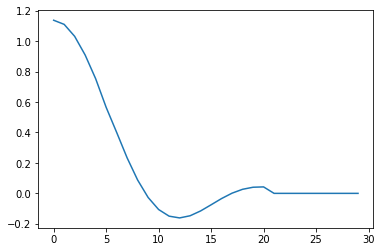

In [29]:
plt.plot(covariance[0])

In [30]:
plt.plot(covariance[5])

## Everything is fine
but we need to add support for direct SNR entry for the channel model, since the SNR at the receiver depends on the current response of the propagation channel

In [65]:
def rc_filter(sampling_freq, roll_off):
    t = np.linspace(-2,2, num=(4*sampling_freq+1))
    rc = np.piecewise(t, [t==0, np.abs(t) == 1/float(2*roll_off), (t!=0) & (np.abs(t) != 1/float(2*roll_off))], [
                    lambda t:1,  
                    lambda t: np.pi/4*np.sin(np.pi/(2*roll_off))/(np.pi/(2*roll_off)), 
                    lambda t:np.sin(np.pi*t)/(np.pi*t)*np.cos(roll_off*np.pi*t)/(1-(2*roll_off*t)**2)])
    return rc

### Power of a discrete signal is defined as

### $\frac{1}{T}\sum_{t=0}^T x(t)^2$

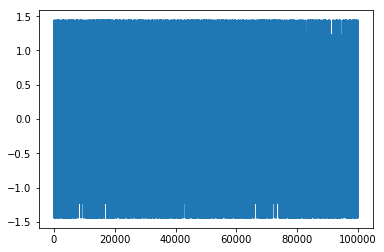

In [66]:
a = rc_filter(10,0.5)
b = np.random.choice([-1,1],10000)
b = b.reshape(len(b),-1)
b = np.pad(b,[(0,0),(0, 10-1)],
           'constant',constant_values=(0))
b = b.reshape(-1)
c = np.convolve(a,b,mode="same")
import matplotlib.pyplot as plt
plt.plot(c)

In [67]:
e = 1/len(c)*np.sum(c**2)
e

0.8708172255911698

In [10]:
c

array([ 1.        ,  0.87175905,  0.68189059,  0.44158307,  0.16740175,
       -0.12004218, -0.39792076, -0.64333149, -0.83552349, -0.9579622 ,
       -1.        , -0.93837112, -0.79139138, -0.57191838, -0.29979806,
        0.        ,  0.29979806,  0.57191838,  0.79139138,  0.93837112,
        1.        ,  0.93837112,  0.79139138,  0.57191838,  0.29979806,
        0.        , -0.29979806, -0.57191838, -0.79139138, -0.93837112,
       -1.        , -0.93837112, -0.79139138, -0.57191838, -0.29979806,
        0.        ,  0.29979806,  0.57191838,  0.79139138,  0.93837112,
        1.        ,  0.97755327,  0.87965559,  0.7147446 ,  0.49604347,
        0.24008435, -0.03500545, -0.31124776, -0.5723898 , -0.80514697,
       -1.        , -1.15752274, -1.28115849, -1.36970692, -1.42281762,
       -1.44050611, -1.42281762, -1.36970692, -1.28115849, -1.15752274,
       -1.        , -0.84432913, -0.66065401, -0.45407398, -0.23125086,
        0.        ,  0.23125086,  0.45407398,  0.66065401,  0.84

In [11]:
c**2

array([1.00000000e+00, 7.59963834e-01, 4.64974782e-01, 1.94995610e-01,
       2.80233464e-02, 1.44101239e-02, 1.58340934e-01, 4.13875407e-01,
       6.98099496e-01, 9.17691570e-01, 1.00000000e+00, 8.80540358e-01,
       6.26300323e-01, 3.27090637e-01, 8.98788756e-02, 0.00000000e+00,
       8.98788756e-02, 3.27090637e-01, 6.26300323e-01, 8.80540358e-01,
       1.00000000e+00, 8.80540358e-01, 6.26300323e-01, 3.27090637e-01,
       8.98788756e-02, 0.00000000e+00, 8.98788756e-02, 3.27090637e-01,
       6.26300323e-01, 8.80540358e-01, 1.00000000e+00, 8.80540358e-01,
       6.26300323e-01, 3.27090637e-01, 8.98788756e-02, 0.00000000e+00,
       8.98788756e-02, 3.27090637e-01, 6.26300323e-01, 8.80540358e-01,
       1.00000000e+00, 9.55610402e-01, 7.73793954e-01, 5.10859841e-01,
       2.46059124e-01, 5.76404956e-02, 1.22538119e-03, 9.68751686e-02,
       3.27630087e-01, 6.48261647e-01, 1.00000000e+00, 1.33985888e+00,
       1.64136707e+00, 1.87609704e+00, 2.02440997e+00, 2.07505784e+00,
      

### Aus irgendeinem Grund dauert das Samplen von einer multivariaten Normalverteilung extrem lange
#### das wird hier noch mal nachvollzogen

In [ ]:
import numpy as np
import time

def rrc_filter(sampling_freq, roll_off):
    t = np.linspace(-2.4,2.4, num=int(4.8*sampling_freq+1))
    rrc = np.piecewise(t, [t==0, np.abs(t) == 1/float(4*roll_off), (t!=0) & (np.abs(t) != 1/float(4*roll_off))], [
        lambda t:(1-roll_off+4*roll_off/np.pi), 
        lambda t: roll_off/np.sqrt(2)*((1+2/np.pi)*np.sin(np.pi/(4*roll_off))+(1-2/np.pi)*np.cos(np.pi/(4*roll_off))),
        lambda t: (np.sin(np.pi*t*(1-roll_off))+4*roll_off*t*np.cos(np.pi*t*(1+roll_off)))/(np.pi*t*(1-(4*roll_off*t)**2))])
    return rrc

noise_filter = rrc_filter(10,0.5)

for i in range(5):
    covariance = np.eye(10**i)
    print(covariance.shape)
    covariance = np.apply_along_axis(lambda m: np.convolve(m, noise_filter), 1, covariance)
    #now throw away everything before the main peak of the first row and everything after the main 
    #peak in the last row
    covariance = covariance[:,int(len(noise_filter)/2):]
    covariance = covariance[:,:-int(np.floor(len(noise_filter)/2))]
    print(covariance.shape)
    
    start = time.time()
    filtered_noise = np.random.multivariate_normal(mean=np.zeros(10**i), cov=covariance)
    stop = time.time()
    
    print("time for ", 10**i,"x",10**i," covarince: ", stop-start)

(1, 1)
(1, 1)
time for  1 x 1  covarince:  0.004044532775878906
(10, 10)
(10, 10)
time for  10 x 10  covarince:  0.0012235641479492188
(100, 100)
(100, 100)
time for  100 x 100  covarince:  0.04803061485290527
(1000, 1000)


/home/stephan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.


(1000, 1000)
time for  1000 x 1000  covarince:  0.7658417224884033
(10000, 10000)
(10000, 10000)
